In [3]:
import networkx as nx
import os

import numpy as np
import random as rd

import matplotlib.pyplot as plt
from networkx.algorithms.dominating import is_dominating_set
from networkx.algorithms.bipartite import is_bipartite
from networkx.algorithms.bipartite.matching import *
from networkx.algorithms.bipartite.covering import *

In [4]:
def load_graph(name):
    with open(name, "r") as f:
        state = 0
        G = None
        for l in f:
            if state == 0:  # Header nb of nodes
                state = 1
            elif state == 1:  # Nb of nodes
                nodes = int(l)
                state = 2
            elif state == 2:  # Header position
                i = 0
                state = 3
            elif state == 3:  # Position
                i += 1
                if i >= nodes:
                    state = 4
            elif state == 4:  # Header node weight
                i = 0
                state = 5
                G = nx.Graph()
            elif state == 5:  # Node weight
                G.add_node(i, weight=int(l))
                i += 1
                if i >= nodes:
                    state = 6
            elif state == 6:  # Header edge
                i = 0
                state = 7
            elif state == 7:
                if i > nodes:
                    pass
                else:
                    edges = l.strip().split(" ")
                    for j, w in enumerate(edges):
                        w = int(w)
                        if w == 1 and (not i == j):
                            G.add_edge(i, j)
                    i += 1

        return G

In [3]:
folder_path = "./rep_data_set/"
filename= "graph_50_50"

In [4]:
g = nx.read_adjlist(os.path.join(folder_path, filename))

In [5]:
graph_loaded = load_graph(folder_path+filename)

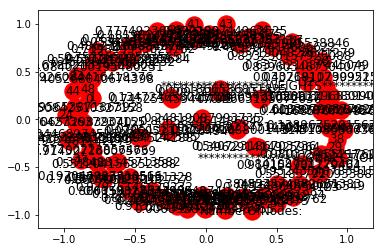

In [6]:
nx.draw_networkx(g)

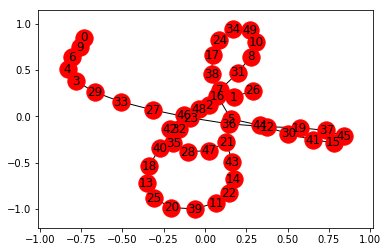

In [7]:
nx.draw_networkx(graph_loaded)

In [8]:
def order_graph(g) :
    """
    sort the graph according to the succession of nodes
    """
    first_node = list(g.nodes)[0] 
    new_graph = [first_node] 
    new_graph.append(list(g[first_node])[0]) 
    while len(new_graph) != g.order() :
        adjacent = list(g[new_graph[-1]]) 
        adjacent.remove(new_graph[-2]) 
        new_graph.append(adjacent[0]) 
    return new_graph

def cycle_dominant(g):
    dominant_set = set()
    ordered_graph = order_graph(g)
    for i in range(0, len(ordered_graph), 3):
        dominant_set.add(ordered_graph[i])
    return dominant_set

def dominant(g):
    """
        A Faire:         
        - Ecrire une fonction qui retourne le dominant du graphe non dirigé g passé en parametre.
        - cette fonction doit retourner la liste des noeuds d'un petit dominant de g
        :param g: le graphe est donné dans le format networkx : https://networkx.github.io/documentation/stable/reference/classes/graph.html
    """
    all_nodes = set(g)
    adjacent_nb = {} 
    for node in all_nodes :
        adjacent_nb[g.degree[node]] = node
    if len(adjacent_nb) == 1 and (g.number_of_nodes() == g.number_of_edges()) : 
        return cycle_dominant(g)
    else :
        max_adjacent = max(adjacent_nb.keys()) 
        max_node = adjacent_nb[max_adjacent]        
        dominating_set = {max_node}
        not_selected = all_nodes - {max_node} 
        all_nodes = all_nodes - set(g[max_node]) - {max_node} 
        g = g.subgraph(not_selected) 
        while all_nodes :
            adjacent_nb = {} 
            for node in not_selected :
                remaining_adjacent = []
                for node2 in list(g[node]) :
                    if node2 in all_nodes :
                        remaining_adjacent.append(node2)
                adjacent_nb[len(remaining_adjacent)] = node
            if len(adjacent_nb) == 1 and (g.number_of_nodes() == g.number_of_edges()) :
                dominating_set |= cycle_dominant(g)
                return dominating_set
            max_adjacent = max(adjacent_nb.keys())
            max_node = adjacent_nb[max_adjacent]
            dominating_set.add(max_node)
            not_selected = not_selected - {max_node}
            all_nodes = all_nodes - set(g[max_node]) - {max_node}
            g = g.subgraph(not_selected)
    return dominating_set

In [9]:
for filename in os.listdir(folder_path):
        graph_loaded = load_graph(os.path.join(folder_path, filename))
        #print(dominant(graph_loaded))

In [10]:
def dominant_baseline(G, start_with=None):
    r"""Finds a dominating set for the graph G.
    A *dominating set* for a graph with node set *V* is a subset *D* of
    *V* such that every node not in *D* is adjacent to at least one
    member of *D* [1]_.
    Parameters
    ----------
    G : NetworkX graph
    start_with : node (default=None)
        Node to use as a starting point for the algorithm.
    Returns
    -------
    D : set
        A dominating set for G.
    Notes
    -----
    This function is an implementation of algorithm 7 in [2]_ which
    finds some dominating set, not necessarily the smallest one.
    See also
    --------
    is_dominating_set
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Dominating_set
    .. [2] Abdol-Hossein Esfahanian. Connectivity Algorithms.
        http://www.cse.msu.edu/~cse835/Papers/Graph_connectivity_revised.pdf
    """
    all_nodes = set(G)
    if start_with is None:
        start_with = nx.utils.arbitrary_element(all_nodes)
    if start_with not in G:
        raise nx.NetworkXError('node {} is not in G'.format(start_with))
    dominating_set = {start_with}
    dominated_nodes = set(G[start_with])
    remaining_nodes = all_nodes - dominated_nodes - dominating_set
    while remaining_nodes:
        # Choose an arbitrary node and determine its undominated neighbors.
        v = remaining_nodes.pop()
        undominated_neighbors = set(G[v]) - dominating_set
        # Add the node to the dominating set and the neighbors to the
        # dominated set. Finally, remove all of those nodes from the set
        # of remaining nodes.
        dominating_set.add(v)
        dominated_nodes |= undominated_neighbors
        remaining_nodes -= undominated_neighbors
    return dominating_set

In [11]:
def evaluate(d,g):
    score = 0
    for node in d:
        score += g.nodes[node]['weight']
    return  score

def ratio(g, dominating_set, remaining_nodes):
    rank = {}
    if dominating_set == {}:
        for node in g:
            rank[node] = len(set(g[node]))/g.nodes[node]['weight']
    else:
        for node in remaining_nodes:
            rank[node] = len(set(g[node]) - dominating_set)/g.nodes[node]['weight']
    return rank

def dominant_ratio(g,method):
    """
        A Faire:         
        - Ecrire une fonction qui retourne le dominant du graphe non dirigé g passé en parametre.
        - cette fonction doit retourner la liste des noeuds d'un petit dominant de g
        :param g: le graphe est donné dans le format networkx : https://networkx.github.io/documentation/stable/reference/classes/graph.html
    """
    all_nodes = set(g)
    start_with = sorted(ratio(g,{},{}).items(), key=lambda item: item[1]).pop()[0]
    dominating_set = {start_with}
    dominated_nodes = set(g[start_with])
    remaining_nodes = all_nodes - dominated_nodes - dominating_set
    while remaining_nodes:
        if method==0:
            v = sorted(ratio(g,dominated_nodes,remaining_nodes).items(), key=lambda item: item[1]).pop()[0]
        else:
            v = sorted(ratio(g,dominated_nodes,all_nodes - dominating_set).items(), key=lambda item: item[1]).pop()[0]
        undominated_neighbors = set(g[v]) - dominating_set
        dominating_set.add(v)
        dominated_nodes |= undominated_neighbors
        remaining_nodes -= undominated_neighbors|{v}
    return dominating_set

def WD0R(g):
    for node in set(g):
        if len(set(g[node]))==0:
            print(node)
    return ''

def WD1R1(g):
    return ''

def WD1R2(g):
    return ''

def WD2R(g):
    return ''

def FastMWDS(g,time):
    """
        A Faire:         
        - l'idée va être d'implémenter cet algo:
        https://www.ijcai.org/proceedings/2018/0210.pdf
    """
    all_nodes = set(g)
    dominating_set = all_nodes
    while is_dominating_set(g, dominating_set):
        v = sorted(ratio(g,dominating_set,remaining_nodes).items(), key=lambda item: item[1]).pop()[-1]
        
    return dominating_set

def dominant(g):
    """
        A Faire:         
        - Ecrire une fonction qui retourne le dominant du graphe non dirigé g passé en parametre.
        - cette fonction doit retourner la liste des noeuds d'un petit dominant de g
        :param g: le graphe est donné dans le format networkx : https://networkx.github.io/documentation/stable/reference/classes/graph.html
    """
    d_1 = dominant_ratio(g,0)
    d_2 = dominant_ratio(g,1)
    score = evaluate(d_1,g)
    score_min = evaluate(d_2,g)
    if score_min < score:
        return d_2
    else:
        return d_1

In [70]:
def scoring(node):
    return ''

def WD0R(g):
    isolated_node = []
    for v in set(g):
        if g.degree[v]==0:
            isolated_node += [v]
    return isolated_node

def WD1R1(g):
    one_node = []
    for v in set(g):
        if g.degree[v]==1:
            u = list(g[v].keys())[0]
            if g.nodes[v]['weight'] > g.nodes[u]['weight']:
                one_node += [u]
    return one_node

def WD1R2(g):
    return ''

def WD2R(g):
    two_node = []
    for v in set(g):
        if g.degree[v]==2:
            u = list(g[v].keys())[0]
            if g.nodes[v]['weight'] > g.nodes[u]['weight']:
                one_node += [u]
    return one_node
    return ''

def BMS(g,d,step):
    """
        - BMS heuristic with random walks
    """
    q = np.random.rand()
    if q < np.exp(-step):
        k = 1024
    else:
        k = 50 + np.random.rand()*10
    v = rd.sample(d, 1)
    score = scoring(v)
    u = v 
    for i in range(int(k)):
        v = rd.sample(d, 1)
        if scoring(v) > score:
            score = scoring(v)
            u = v 
    return v

for graph_filename in sorted(os.listdir(input_dir)):
    g = load_graph(os.path.join(input_dir, graph_filename))
    WD1R1(g)

In [1]:
import sys, os, time
import networkx as nx

#Pour effectuer des tirages aléatoires de sommets dans les construction de solution greedy ou naïves
import random
from networkx.algorithms.assortativity import neighbor_degree

from networkx.algorithms.bipartite.matrix import from_biadjacency_matrix
from networkx.algorithms.clique import number_of_cliques

def W(S,g):
    """Pour une solution S donnée calcule la somme des poids des sommets"""
    res = 0
    weight = g.nodes(data = "weight", default=1)
    for node in S:
        res += weight[node]
    return res

def tri_2_arg(list):
    """Prend une liste de couple (a,b) et la trie selon les valeurs de b dans l'ordre croissant"""
    random.shuffle(list)
    return sorted(list, key = lambda x: x[1])


def remove_useless_nodes(S,g,i):

    res = S
    d = g.nodes(data = "weight", default=1)
    redundant_nodes = []
    for node in S:
        temp = S.copy()
        temp.remove(node)
        if nx.is_dominating_set(g,temp):
            redundant_nodes.append(node)

    if redundant_nodes == []:
        return res

    else:
    
        removed = res.copy()
        for node in redundant_nodes:
            removed.remove(node)

        if i == 2:
            new_res = H2(removed,g)
            
        if i == 3: 
            new_res = H3(removed,g)
            
        if i == 4: 
            new_res = H4(removed,g)
            
        if i == 5: 
            new_res = H5(removed,g)

        if W(new_res,g) < W(res,g):
            res = new_res
            res = remove_useless_nodes(res,g,i)
        else:
            for i in range(len(redundant_nodes)):
                redundant_nodes[i] = [redundant_nodes[i], d[i]/g.degree(i)]
            redundant_nodes = tri_2_arg(redundant_nodes)
            while redundant_nodes != []:
                node_to_remove = redundant_nodes[-1][0]
                res.remove(node_to_remove)
                redundant_nodes = []
                for node in S:
                    temp = S.copy()
                    temp.remove(node)
                    if nx.is_dominating_set(g,temp):
                        redundant_nodes.append([node, d[node]/g.degree[node]])
          

    return res


def get_isolated_nodes(g):
    res = []
    for n in g.nodes():
        if g.degree[n] == 0:
            res.append(n)
    return res

def H2(S,g):

    res = S.copy()

    candidate_nodes = [node for node in g.nodes() if not node in res]


    weight = g.nodes(data = "weight", default=1)

    Ws = {}
    Wout = {}
    color = {}

    for node in g.nodes():
        color[node] = 1

    for node in g.nodes():
        if node in res:
            color[node] = 0
            for i in g.neighbors(node):
                if color[i] == 1:
                    color[i] = -1
    for node in g.nodes():
        Ws[node] = 0
        Wout[node] = 0
        for i in g.neighbors(node):
            if color[i] == 1:
                Ws[node] += weight[i]
                Wout[node] += 1

    isolated_nodes = get_isolated_nodes(g)

    for node in isolated_nodes:
            if not node in res:
                res.append(node)
                color[node] = 0
   

    while not nx.is_dominating_set(g,res):
        node_list_score = []
        max_score = 0
        for node in candidate_nodes:
            score = (Ws[node] + weight[node] * color[node])/(weight[node])
            if score > max_score:
                max_score = score
            node_list_score.append([node,score])
        
        best_nodes = [i for i in node_list_score if i[1] == max_score]

        if len(best_nodes) == 1:
            new_node = best_nodes[-1][0]
        else:
            for i in best_nodes:
                i[1] = (Wout[i[0]] + color[i[0]])/weight[i[0]]
            best_nodes = tri_2_arg(best_nodes)
            new_node = best_nodes[-1][0]        
        
        res.append(new_node)

        candidate_nodes.remove(new_node)

        color[new_node] = 0 #Le sommet choisi devient noir

        for i in g.neighbors(new_node):
            if color[i] ==1:
                color[i] = -1
                for j in g.neighbors(i):
                    Ws[j] -= weight[i]
                    Wout[j] -= 1 
        


    res = remove_useless_nodes(res,g,2)
    
    return res

def H3(S,g):
    res = S.copy()

    candidate_nodes = list(g.nodes())

    for node in res:
        candidate_nodes.remove(node)

    weight = g.nodes(data = "weight", default=1)

    Ws = {}
    Wout = {}
    color = {}
    deg = {}

    for node in g.nodes():
        color[node] = 1

    for node in g.nodes():
        if node in res:
            color[node] = 0
            for i in g.neighbors(node):
                if color[i] == 1:
                    color[i] = -1
        else:
            color[node] = 1
    for node in g.nodes():
        Ws[node] = 0
        Wout[node] = 0
        deg[node] = g.degree[node]
        for i in g.neighbors(node):
            if color[i] == 1:
                Ws[node] += weight[i]
                Wout[node] += 1

    isolated_nodes = get_isolated_nodes(g)

    for node in isolated_nodes:
            if not node in res:
                res.append(node)
                color[node] = 0
   

    while not nx.is_dominating_set(g,res):
        node_list_score = []
        max_score = 0
        for node in candidate_nodes:
            score = (Ws[node] + weight[node] * color[node])/(weight[node])
            if score > max_score:
                max_score = score
            node_list_score.append([node,score])
        
        best_nodes = [i for i in node_list_score if i[1] == max_score]

        if len(best_nodes) == 1:
            new_node = best_nodes[-1][0]
        else:
            white_best_nodes = []
            for i in best_nodes:
                if color[i[0]] == 1:
                    white_best_nodes.append(i)
            if len(white_best_nodes) == 1:
                new_node =  white_best_nodes[-1][0]
            elif len(white_best_nodes) > 1:
                for i in white_best_nodes:
                    i[1] = deg[i[0]]
                white_best_nodes = tri_2_arg(white_best_nodes)
                new_node = white_best_nodes[0][0]
            else: # pas de sommet blanc
                new_node = best_nodes[random.randint(0, len(best_nodes)-1)][0]

        
        res.append(new_node)

        candidate_nodes.remove(new_node)

        color[new_node] = 0 #Le sommet choisi devient noir

        for i in g.neighbors(new_node):
            if color[i] == 1:
                color[i] = -1 #Ses voisins deviennent gris
        
        for node in g.nodes():
            Ws[node]=0
            Wout[node]=0
            for i in g.neighbors(node):
                if color[i] == 1:
                    Ws[node] += weight[i]
                    Wout[node] += 1

    res = remove_useless_nodes(res,g,3)

    return res





def H4(S,g):
    """Crée une solution de manière glouton
    """

    res = S.copy()

    candidate_nodes = list(g.nodes())

    for node in res:
        candidate_nodes.remove(node)

    weight = g.nodes(data = "weight", default=1)

    Ws = {}
    Wout = {}
    color = {}
    deg = {}

    for node in g.nodes():
        color[node] = 1

    for node in g.nodes():
        if node in res:
            color[node] = 0
            for i in g.neighbors(node):
                if color[i] == 1:
                    color[i] = -1
        else:
            color[node] = 1
    for node in g.nodes():
        Ws[node] = 0
        Wout[node] = 0
        deg[node] = g.degree[node]
        for i in g.neighbors(node):
            if color[i] == 1:
                Ws[node] += weight[i]
                Wout[node] += 1

    isolated_nodes = get_isolated_nodes(g)

    for node in isolated_nodes:
            if not node in res:
                res.append(node)
                color[node] = 0
   

    while not nx.is_dominating_set(g,res):
        

        exist = False
        for n in g.nodes():
            if color[n] == 1:
                no_white_neigh = True
                non_black_neigh = 0
                for i in g.neighbors(n):
                    if color[i] == 1:
                        no_white_neigh = False
                    if color[i] != 0:
                        non_black_neigh += 1
                        m = i
                if no_white_neigh and non_black_neigh == 1:
                    u = n
                    v = m
                    exist = True

        if exist:
            score_u = (Ws[u] + weight[u] * color[u])/(weight[u])
            score_v = (Ws[v] + weight[v] * color[v])/(weight[v])

            if score_u > score_v:
                new_node = u
            else:
                new_node = v

        else:
        
            node_list_score = []
            max_score = 0
            for node in candidate_nodes:
                score = (Ws[node] + weight[node] * color[node])/(weight[node])
                if score > max_score:
                    max_score = score
                node_list_score.append([node,score])
            
            best_nodes = [i for i in node_list_score if i[1] == max_score]

            if len(best_nodes) == 1:
                new_node = best_nodes[-1][0]
            else:
                for i in best_nodes:
                    i[1] = (Wout[i[0]] + color[i[0]])/weight[i[0]]
                best_nodes = tri_2_arg(best_nodes)
                new_node = best_nodes[-1][0]        
        
        res.append(new_node)

        candidate_nodes.remove(new_node)

        color[new_node] = 0 #Le sommet choisi devient noir

        for i in g.neighbors(new_node):
            if color[i] == 1:
                color[i] = -1 #Ses voisins blancs deviennent gris
        
        for node in g.nodes():
            Ws[node]=0
            Wout[node]=0
            for i in g.neighbors(node):
                if color[i] == 1:
                    Ws[node] += weight[i]
                    Wout[node] += 1

    res = remove_useless_nodes(res,g,4)
    
    return res


def H5(S,g):
    res = S

    candidate_nodes = list(g.nodes())

    for node in res:
        candidate_nodes.remove(node)

    weight = g.nodes(data = "weight", default=1)

    Ws = {}
    Wout = {}
    color = {}
    deg = {}

    for node in g.nodes():
        color[node] = 1

    for node in g.nodes():
        if node in res:
            color[node] = 0
            for i in g.neighbors(node):
                if color[i] == 1:
                    color[i] = -1

        else:
            color[node] = 1
    for node in g.nodes():
        Ws[node] = 0
        Wout[node] = 0
        deg[node] = g.degree[node]
        for i in g.neighbors(node):
            if color[i] == 1:
                Ws[node] += weight[i]
                Wout[node] += 1

    isolated_nodes = get_isolated_nodes(g)

    for node in isolated_nodes:
            if not node in res:
                res.append(node)
                color[node] = 0
   

    while not nx.is_dominating_set(g,res):
        

        exist = False
        for n in g.nodes():
            if color[n] == 1:
                no_white_neigh = True
                non_black_neigh = 0
                for i in g.neighbors(n):
                    if color[i] == 1:
                        no_white_neigh = False
                    if color[i] != 0:
                        non_black_neigh += 1
                        m = i
                if no_white_neigh and non_black_neigh == 1:
                    u = n
                    v = m
                    exist = True

        if exist:
            score_u = (Ws[u] + weight[u] * color[u])/(weight[u])
            score_v = (Ws[v] + weight[v] * color[v])/(weight[v])

            if score_u > score_v:
                new_node = u
            else:
                new_node = v

        else:
        
            node_list_score = []
            max_score = 0
            for node in candidate_nodes:
                score = (Ws[node] + weight[node] * color[node])/(weight[node])
                if score > max_score:
                    max_score = score
                node_list_score.append([node,score])
        
            best_nodes = [i for i in node_list_score if i[1] == max_score]

            if len(best_nodes) == 1:
                new_node = best_nodes[-1][0]
            else:
                white_best_nodes = []
                for i in best_nodes:
                    if color[i[0]] == 1:
                        white_best_nodes.append(i)
                if len(white_best_nodes) == 1:
                    new_node =  white_best_nodes[-1][0]
                elif len(white_best_nodes) > 1:
                    for i in white_best_nodes:
                        i[1] = deg[i[0]]
                    white_best_nodes = tri_2_arg(white_best_nodes)
                    new_node = white_best_nodes[0][0]
                else: # pas de sommet blanc
                    new_node = best_nodes[random.randint(0, len(best_nodes)-1)][0]        
        
        res.append(new_node)

        candidate_nodes.remove(new_node)

        color[new_node] = 0 #Le sommet choisi devient noir

        for i in g.neighbors(new_node):
            if color[i] == 1:
                color[i] = -1 #Ses voisins blancs deviennent gris
        
        for node in g.nodes():
            Ws[node]=0
            Wout[node]=0
            for i in g.neighbors(node):
                if color[i] == 1:
                    Ws[node] += weight[i]
                    Wout[node] += 1

    res = remove_useless_nodes(res,g,5)
    
    return res


def solve_dom_randomized(g):
    """Construit et déstruit en partie les solutions créées par l'algorithme H2 (qui est le plus rapide) en boucle tout en gardant le meilleur dominant au fur et a mesure."""
    S = H2([],g) 
    proportion_to_del =  0.5
    for i in range(25):
        infeasible_S = S.copy()
        number_of_nodes_to_del = int(proportion_to_del*len(infeasible_S))
        for k in range(number_of_nodes_to_del):
            infeasible_S.pop(random.randint(0,len(infeasible_S)-1))
        new_S = H2(infeasible_S,g)
        if W(new_S,g) < W(S,g):
            S = new_S
    return S


def dominant(g):
    """
        A Faire:         
        - Ecrire une fonction qui retourne le dominant du graphe non dirigé g passé en parametre.
        - cette fonction doit retourner la liste des noeuds d'un petit dominant de g

        :param g: le graphe est donné dans le format networkx : https://networkx.github.io/documentation/stable/reference/classes/graph.html

    """
    res = solve_dom_randomized(g)

In [7]:
import sys, os, time
import networkx as nx

#Pour effectuer des tirages aléatoires 
import random

def evaluate(d,g):
    """Pour un sous-ensemble d donné on évalue la somme des poids des nodes"""
    score = 0
    for node in d:
        score += g.nodes[node]['weight']
    return  score

def tri_2_arg(list):
    """Prend une liste de couple (a,b) et la trie selon les valeurs de b dans l'ordre croissant"""
    random.shuffle(list)
    return sorted(list, key = lambda x: x[1])

def remove_useless_nodes(S,g,i):
    solution = S
    d = g.nodes(data = "weight", default=1)
    redundant_nodes = []
    for node in S:
        temp_set = S.copy()
        temp_set.remove(node)
        if nx.is_dominating_set(g,temp_set):
            redundant_nodes.append(node)
    if redundant_nodes == []:
        return solution
    else:  
        removed = solution.copy()
        for node in redundant_nodes:
            removed.remove(node)
        if i == 2:
            new_solution = heuristic(removed,g)
        if evaluate(new_solution,g) < evaluate(solution,g):
            solution = new_solution
            solution = remove_useless_nodes(solution,g,i)
        else:
            for i in range(len(redundant_nodes)):
                redundant_nodes[i] = [redundant_nodes[i], d[i]/g.degree(i)]
            redundant_nodes = tri_2_arg(redundant_nodes)
            while redundant_nodes != []:
                node_to_remove = redundant_nodes[-1][0]
                solution.remove(node_to_remove)
                redundant_nodes = []
                for node in S:
                    temp_set = S.copy()
                    temp_set.remove(node)
                    if nx.is_dominating_set(g,temp_set):
                        redundant_nodes.append([node, d[node]/g.degree[node]])
    return solution

def get_isolated_nodes(g):
    solution= []
    for n in g.nodes():
        if g.degree[n] == 0:
            solution.append(n)
    return solution

def heuristic(S,g):
    solution= S.copy()
    candidate_nodes = [node for node in g.nodes() if not node in solution]
    weights = g.nodes(data = "weight", default=1)
    Ws = {}
    Wout = {}
    color = {}
    for node in g.nodes():
        color[node] = 1
    for node in g.nodes():
        if node in solution:
            color[node] = 0
            for i in g.neighbors(node):
                if color[i] == 1:
                    color[i] = -1
    for node in g.nodes():
        Ws[node] = 0
        Wout[node] = 0
        for i in g.neighbors(node):
            if color[i] == 1:
                Ws[node] += weights[i]
                Wout[node] += 1
    isolated_nodes = get_isolated_nodes(g)
    for node in isolated_nodes:
            if not node in solution:
                solution.append(node)
                color[node] = 0
    while not nx.is_dominating_set(g,solution):
        node_list_score = []
        max_score = 0
        for node in candidate_nodes:
            score = (Ws[node] + weights[node] * color[node])/(weights[node])
            if score > max_score:
                max_score = score
            node_list_score.append([node,score])
        best_nodes = [i for i in node_list_score if i[1] == max_score]
        if len(best_nodes) == 1:
            new_node = best_nodes[-1][0]
        else:
            for i in best_nodes:
                i[1] = (Wout[i[0]] + color[i[0]])/weights[i[0]]
            best_nodes = tri_2_arg(best_nodes)
            new_node = best_nodes[-1][0]        
        solution.append(new_node)
        candidate_nodes.remove(new_node)
        color[new_node] = 0 #Le sommet choisi devient noir
        for i in g.neighbors(new_node):
            if color[i] ==1:
                color[i] = -1
                for j in g.neighbors(i):
                    Ws[j] -= weights[i]
                    Wout[j] -= 1 
    solution= remove_useless_nodes(solution,g,2)
    return solution

def randomize_dominant(g, proportion_to_delete, rounds):
    """Construit et déstruit en partie les solutions créées par l'algorithme H2 (qui est le plus rapide) en boucle tout en gardant le meilleur dominant au fur et a mesure."""
    S = heuristic([],g) 
    proportion_to_del =  proportion_to_delete
    for i in range(rounds):
        infeasible_S = S.copy()
        number_of_nodes_to_del = int(proportion_to_del*len(infeasible_S))
        for k in range(number_of_nodes_to_del):
            infeasible_S.pop(random.randint(0,len(infeasible_S)-1))
        new_S = heuristic(infeasible_S,g)
        if evaluate(new_S,g) < evaluate(S,g):
            S = new_S
    return S

def dominant(g):
    """
        A Faire:         
        - Ecrire une fonction qui retourne le dominant du graphe non dirigé g passé en parametre.
        - cette fonction doit retourner la liste des noeuds d'un petit dominant de g

        :param g: le graphe est donné dans le format networkx : https://networkx.github.io/documentation/stable/reference/classes/graph.html
    """
    solution = randomize_dominant(g, 0.5, 25)
    return solution

In [6]:
from networkx.algorithms import dominating_set

input_dir = os.path.abspath('test_dataset')
t = 0
baseline = 0

for graph_filename in sorted(os.listdir(input_dir)):
    s = 0
    # importer le graphe
    g = load_graph(os.path.join(input_dir, graph_filename))

    # calcul du dominant
    B = sorted(dominating_set(g), key=lambda x: int(x))
    D = sorted(dominant(g), key=lambda x: int(x))
    
    if not is_dominating_set(g, D):
        print('[DOMINATION ERROR]: Not a dominating set')
    
    for node in B:
        baseline += g.nodes[node]['weight']
    
    for node in D:
        s += g.nodes[node]['weight']
        t += g.nodes[node]['weight']
        
    print(graph_filename)        
    #print(D)
    print("Sum of dominant nodes: " + str(s))
    print("Nb of dominant nodes: " + str(len(D)) + '/' + str(len(g)))
    
    print('-------')
    
print(str(t) + ' vs baseline: ' + str(baseline))

graph_100_100
Sum of dominant nodes: 1116
Nb of dominant nodes: 36/100
-------
graph_100_1000
Sum of dominant nodes: 225
Nb of dominant nodes: 9/100
-------
graph_100_250
Sum of dominant nodes: 671
Nb of dominant nodes: 24/100
-------
graph_100_500
Sum of dominant nodes: 367
Nb of dominant nodes: 14/100
-------
graph_250_1000
Sum of dominant nodes: 1252
Nb of dominant nodes: 45/250
-------
graph_250_250
Sum of dominant nodes: 2848
Nb of dominant nodes: 98/250
-------
graph_250_500
Sum of dominant nodes: 2001
Nb of dominant nodes: 67/250
-------
graph_500_1000
Sum of dominant nodes: 3887
Nb of dominant nodes: 135/500
-------
graph_500_500
Sum of dominant nodes: 5612
Nb of dominant nodes: 194/500
-------
graph_50_1000
Sum of dominant nodes: 43
Nb of dominant nodes: 2/50
-------
graph_50_250
Sum of dominant nodes: 188
Nb of dominant nodes: 7/50
-------
graph_50_50
Sum of dominant nodes: 552
Nb of dominant nodes: 18/50
-------
graph_50_500
Sum of dominant nodes: 121
Nb of dominant nodes: 5

In [14]:
results = []
for i in range(10):
    for j in np.arange(10,30):
        scores = []
        for graph_filename in sorted(os.listdir(input_dir)):
            g = load_graph(os.path.join(input_dir, graph_filename))
            D = sorted(randomize_dominant(g, proportion_to_delete, rounds), key=lambda x: int(x))
            proportion_to_delete = i/10
            rounds = j
            for cv in range(30):
                scores += [evaluate(D,g)]
    results += [proportion_to_delete, rounds, np.mean(scores)]
print(results)

[0.0, 29, 1504.5384615384614, 0.1, 29, 1474.3076923076924, 0.2, 29, 1449.923076923077, 0.3, 29, 1446.076923076923, 0.4, 29, 1439.923076923077, 0.5, 29, 1445.3076923076924, 0.6, 29, 1449.0, 0.7, 29, 1442.3076923076924, 0.8, 29, 1452.3846153846155, 0.9, 29, 1456.0]
